Please make a copy of the nore in your local drive for saving the changes on local. File -> Save a copy in Drive

In [1]:
# Mounting the google drive and change the directory
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
!git clone https://github.com/mukul74/Error_comparision.git
%cd /content/drive/MyDrive/Error_comparision/
print("Current WORKING DIRECTORY : ")
!pwd
print("Folders available in the project : ")
!ls

Cloning into 'Error_comparision'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 49 (delta 10), reused 46 (delta 7), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/drive/MyDrive/Error_comparision
Current WORKING DIRECTORY : 
/content/drive/MyDrive/Error_comparision
Folders available in the project : 
audio_decoder.py				optimfuncMDCT.py
audio_encoder.py				optimfuncQMF.py
Audiophile_vocal_dataset_mono_8000_chunk_4.wav	polmatmult.py
DCT4.py						polyphase2x.py
DCTo.py						PQMFB.py
Dinvmatrix.py					PQMF_Skript.py
Dmatrix.py					psyacmodel.py
Fa2h.py						psyacpostfilterFromFile.py
Ginvmatrix.py					psyacprefilterToFile.py
Gmatrix.py					psyacprepostfilter.py
IntMDCTfb.py					psyac_quantization.py
LDFB.py						PythonPsychoacoustics
MDCTfb.py					symFmatrix.py
optimfuncLDFB.py				x2polyphase.py


Installing libraries for the code

In [3]:
!pip install librosa==0.9.1
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install torch
!pip install torchaudio

     |████████████████████████████████| 213 kB 5.0 MB/s 
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


Importing the libraries for the code

In [4]:
import os
import torch
import librosa
import numpy as np
from scipy import signal
import IPython.display as ipd
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio, display

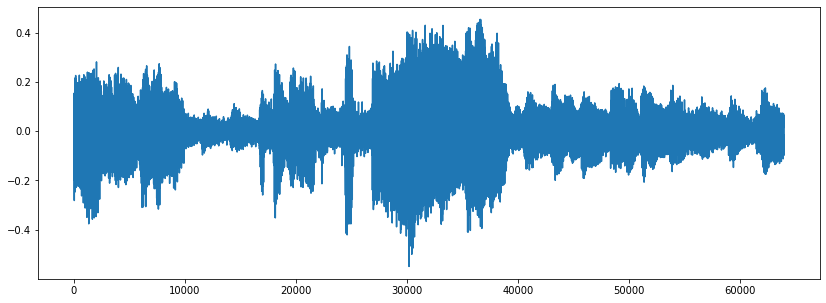

In [10]:
y_original, sr = librosa.load('Audiophile_vocal_dataset_mono_8000_chunk_4.wav', sr=None)
plt.figure(figsize=(14, 5))
plt.plot(y_original)
Audio(y_original,rate=sr)

In [7]:
# Starting Compression
!python psyacprefilterToFile.py Audiophile_vocal_dataset_mono_8000_chunk_4.wav 100.0

audiofile= Audiophile_vocal_dataset_mono_8000_chunk_4.wav
channels= 1
Prefiltered file: Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_pref.wav
Masking Threshold file name: Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_mT.wav
Compute Prefilter
channel  0
quality= 100.0
Computing MDCT for sound file,
masking threshold calculation,
quantization according to the masking threshold,
xpref.shape= (64256,)
mTbarkquantflattened.shape (1, 32064)


In [8]:
# Starting Decompression
!python psyacpostfilterFromFile.py Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_pref.wav 

prefiltered audiofile= Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_pref.wav
Masking Threshold file name: Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_mT.wav
channels= 1
blocks= 501
channel  0
Compute Postfilter
yq.shape= (128, 500)
Inverse MDCT
xrek.shape= (64128,)
Write to Postfiltered file: Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_postf.wav


In [11]:
# Reconstructed audio file
y_reconstructed, sr = librosa.load('Audiophile_vocal_dataset_mono_8000_chunk_4_100.0_postf.wav', sr=None)
y_reconstructed = y_reconstructed[0:(y_original.shape[0])]

In [12]:
# Calculate the SNR
RMS_signal = np.sqrt(np.mean(y_original**2))
RMS_noise = np.sqrt(np.mean((y_original-y_reconstructed)**2))
SNR_RMS = 20*np.log10(RMS_signal/RMS_noise)
print(SNR_RMS)

-3.6120060086250305


In [13]:
# White noise for the mentioned SNR
RMS_s=np.sqrt(np.mean(y_original**2))
RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR_RMS/10)))
STD_n=RMS_n
noise = np.random.normal(0, STD_n, y_original.shape[0])

# White noise added signal of same SNR as specfified
y_noisy_signal = y_original + noise

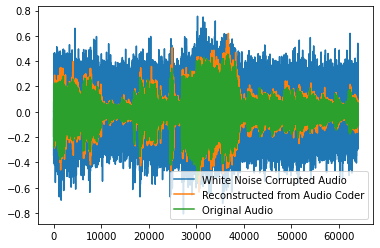

In [14]:
# PLottig the Original, Reconstructed and White noise added signal
plt.plot(y_noisy_signal, label='White Noise Corrupted Audio')
plt.plot(y_reconstructed, label='Reconstructed from Audio Coder')
plt.plot(y_original, label='Original Audio')
plt.legend(loc='best')
plt.show()


In [15]:
# Writing the white gaussian noise signal
wav.write("White_noise_added_signal.wav", sr, y_noisy_signal.astype('float32'))


In [16]:
# MSE comparision for Audio coder reconstruceted and white_noise added signal
MSE_AudioCoded_Signal = ((y_reconstructed - y_original) ** 2).mean(axis=0)
MSE_WhiteNoise_Signal = ((y_noisy_signal - y_original) ** 2).mean(axis=0)

In [17]:
# Generate the Weighted Perceptual  Perceptual Loss for AudioCodec Reconstructed and White Noise Added Signal
gamma_1 = 0.9
gamma_2 = 0.6 
Coef_num = 8
freq_coeff_leng = Coef_num + 1

a = librosa.lpc(y_original, order=Coef_num)
a_temp = a[1:Coef_num+1]
a_gamma1 = np.zeros((1, Coef_num))
a_gamma1[0,0] = 1
a_gamma2 = np.zeros((1, Coef_num))
a_gamma2[0,0] = 1

worn = 1024

for k1 in range(1,Coef_num):
    a_gamma1[0, k1 ] = a[k1] * np.power(gamma_1, k1)
    a_gamma2[0, k1 ] = a[k1] * np.power(gamma_2, k1)

w1, freqz_amp_values = signal.freqz(a_gamma2[0,:], a_gamma1[0,:], worN=worn , fs=sr)
w2, lpc_a = signal.freqz(1, a, worN=worn ,fs=sr)
w3, audio_orig = signal.freqz(y_original,1,worN=worn ,fs=sr)
w4, audio_reconstructed = signal.freqz(y_reconstructed,1,worN=worn ,fs=sr)
w5, audio_rnoisy = signal.freqz(y_noisy_signal,1,worN=worn ,fs=sr)

In [18]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


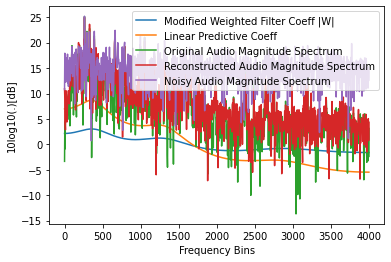

In [19]:
plt.figure()
plt.plot(w1, 10*np.log10(np.abs(freqz_amp_values)), label='Modified Weighted Filter Coeff |W|')
plt.plot(w2, 10*np.log10(np.abs(lpc_a)), label='Linear Predictive Coeff')
plt.plot(w3, 10*np.log10(np.abs(audio_orig)), label='Original Audio Magnitude Spectrum')
plt.plot(w4, 10*np.log10(np.abs(audio_reconstructed)), label='Reconstructed Audio Magnitude Spectrum')
plt.plot(w5, 10*np.log10(np.abs(audio_rnoisy)), label='Noisy Audio Magnitude Spectrum')
# plt.plot(w6, 10*np.log10(np.abs(audio_codec_error)), label='Error b/w Orig and Audio Codec Magnitude Spectrum')
# plt.plot(w7, 10*np.log10(np.abs(white_noise_error)), label='Error b/w Orig and White noise corrupted Magnitude Spectrum')

plt.legend(loc='best')
plt.ylabel('10log10(.)[dB]')
plt.xlabel('Frequency Bins')
plt.show()


In [20]:
f, t, Zxx_original = signal.stft(y_original,fs=sr,nperseg=2046)
f, t, Zxx_reconstructed = signal.stft(y_reconstructed,fs=sr,nperseg=2046)
f, t, Zxx_noisy_signal = signal.stft(y_noisy_signal,fs=sr,nperseg=2046)

MSE_error_STFT_Audio_coded =  ((np.abs(Zxx_original) - np.abs(Zxx_reconstructed))**2).mean(axis=1)
Weighted_MSE_error_STFT_Audio_codec = (MSE_error_STFT_Audio_coded/np.abs(freqz_amp_values)).mean()

MSE_error_STFT_Noisy=  ((np.abs(Zxx_original) - np.abs(Zxx_noisy_signal))**2).mean(axis=1)
Weighted_MSE_error_STFT_White_noise = (MSE_error_STFT_Noisy/np.abs(freqz_amp_values)).mean()

STFT_Original_torch = torch.stft(torch.from_numpy(y_original).unsqueeze(dim=0), n_fft=2046, return_complex=True)
STFT_Reconstructed_torch = torch.stft(torch.from_numpy(y_reconstructed).unsqueeze(dim=0), n_fft=2046, return_complex=True)
STFT_NoiseCorrupted_torch = torch.stft(torch.from_numpy(y_noisy_signal).unsqueeze(dim=0), n_fft=2046, return_complex=True)

MSE_error_STFT_Audio_coded_torch =  ((torch.abs(STFT_Original_torch) - torch.abs(STFT_Reconstructed_torch))**2).mean(dim=2)
Weighted_MSE_error_STFT_Audio_codec_torch = torch.div(MSE_error_STFT_Audio_coded_torch,torch.abs(torch.from_numpy(freqz_amp_values))).mean(dim=1)

MSE_error_STFT_Noisy_torch=  ((torch.abs(STFT_Original_torch) - torch.abs(STFT_NoiseCorrupted_torch))**2).mean(dim=2)
Weighted_MSE_error_STFT_White_noise_torch = (MSE_error_STFT_Noisy_torch/torch.abs(torch.from_numpy(freqz_amp_values))).mean(dim=1)

In [21]:
print("#"*100)
print("MSE for AudioCoded vs Original", MSE_AudioCoded_Signal)
print("MSE for WhiteNoise vs Original", MSE_WhiteNoise_Signal)
print("#"*100)
print("Weighted MSE for AudioCoded vs Original", format(Weighted_MSE_error_STFT_Audio_codec, '.8f'))
print("Weighted MSE for WhiteNoise vs Original", format(Weighted_MSE_error_STFT_White_noise, '.8f'))
print("#"*100)
print("Weighted MSE for AudioCoded vs Original", (Weighted_MSE_error_STFT_Audio_codec))
print("Weighted MSE for WhiteNoise vs Original", (Weighted_MSE_error_STFT_White_noise))
print("#"*100)
print("Weighted MSE for AudioCoded vs Original TORCH", (Weighted_MSE_error_STFT_Audio_codec_torch.item()))
print("Weighted MSE for WhiteNoise vs Original TORCH", (Weighted_MSE_error_STFT_White_noise_torch.item()))
print("#"*100)
print("STFT MSE for AudioCOde vs Original TORCH",  ((MSE_error_STFT_Audio_coded_torch).mean(dim=1)).item())
print("STFT MSE for WhiteNoise vs Original TORCH",  ((MSE_error_STFT_Noisy_torch).mean(dim=1)).item())
print("#"*100)


####################################################################################################
MSE for AudioCoded vs Original 0.018863622
MSE for WhiteNoise vs Original 0.01916554253623433
####################################################################################################
Weighted MSE for AudioCoded vs Original 0.00000052
Weighted MSE for WhiteNoise vs Original 0.00001269
####################################################################################################
Weighted MSE for AudioCoded vs Original 5.194303229423239e-07
Weighted MSE for WhiteNoise vs Original 1.2692241892388269e-05
####################################################################################################
Weighted MSE for AudioCoded vs Original TORCH 1.4695677872639454
Weighted MSE for WhiteNoise vs Original TORCH 35.54878049681757
####################################################################################################
STFT MSE for AudioCOde vs Original TORCH 2.31